# Final Project – Regression on Medical Cost Dataset

**Author:** Beth Spornitz  
**Date:** November 16, 2025  

## Introduction  

In this project, I will build and evaluate a regression model using the Medical Cost Dataset.

I will follow a structured workflow:

- Import and inspect the raw data  
- Explore patterns, anomalies, and data quality issues  
- Prepare and engineer features for modeling  
- Train a baseline linear regression model  
- Improve the model using Scikit-Learn Pipelines  
- Reflect on performance, tradeoffs, and next steps  

This notebook is organized with numbered sections and reflections after each major step.


### Imports

In [1]:

import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


## Section 1. Import and Inspect the Data

### Section 1.1 Load the dataset and display the first 10 rows

In [2]:
data_path = r"C:\Repos\ml_regression_bethspornitz\notebooks\regression_final\data\insurance.csv"
df = pd.read_csv(data_path)


print("Shape of dataset:", df.shape)
df.head(10)


Shape of dataset: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


# Section 1.2 Check for missing values and display summary statistics



In [3]:
# Check for missing values
print("=== Missing values per column ===")
print(df.isna().sum())



=== Missing values per column ===
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
# Display summary statistics
print("\n=== Summary statistics (numeric columns) ===")
df.describe()


=== Summary statistics (numeric columns) ===


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Reflection 1

- What do you notice about the dataset?  
  - There are no missing values.
  - Age ranges from 18-64 with a mean of about 39.  There are no extreme outliers.
  - BMI - Mean ~ 30.66.  There is one very high maximum BMI of 53.13 but it is still realistic.
  - Charges have a very wide range and are highly skewed.

- Are there any data issues?  
  - There do not appear to be any data issues.


## Section 2. Data Exploration and Preparation

### 2.1 Explore Data Patterns and Distributions


In [5]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['age', 'bmi', 'children', 'charges']
Categorical columns: ['sex', 'smoker', 'region']


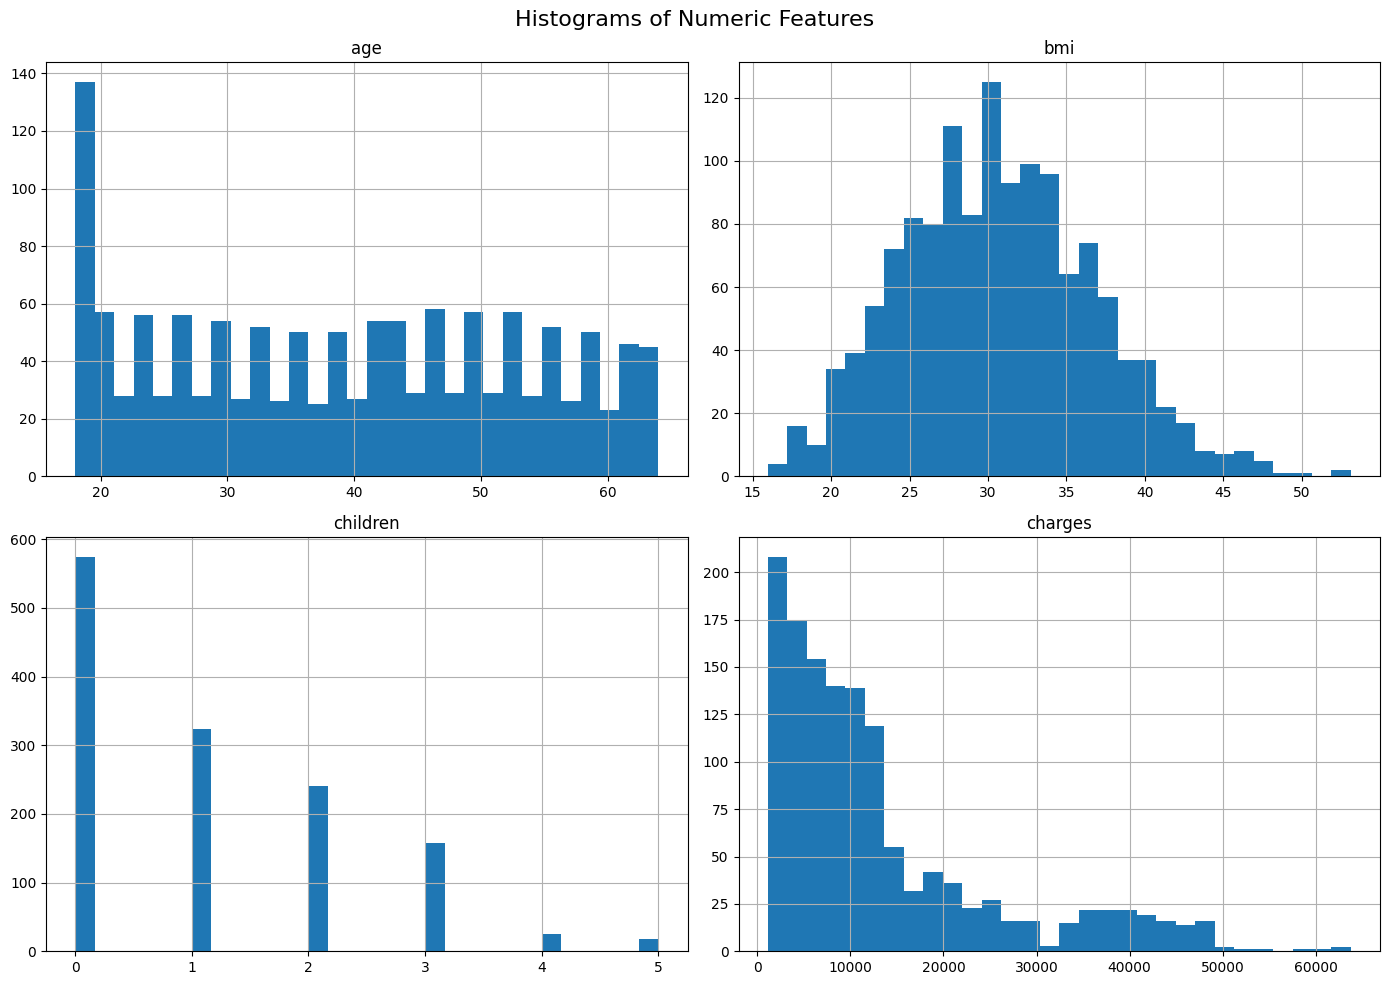

In [6]:
# Histograms for numeric features

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


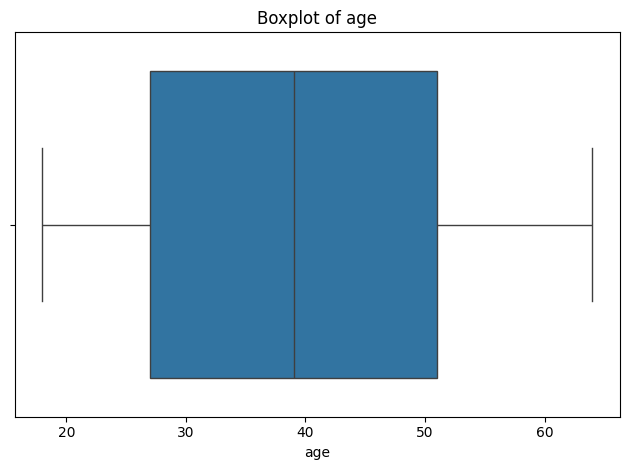

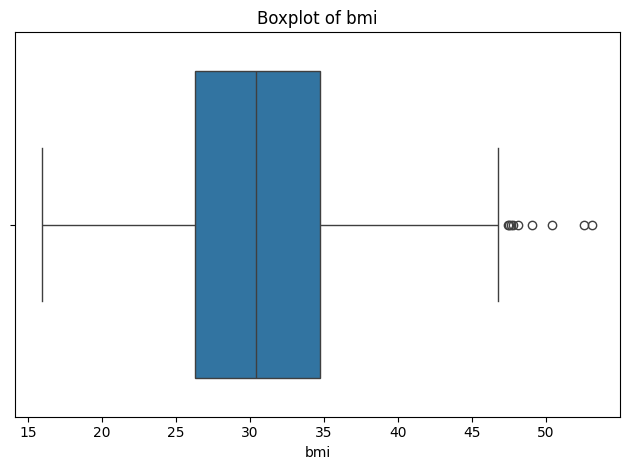

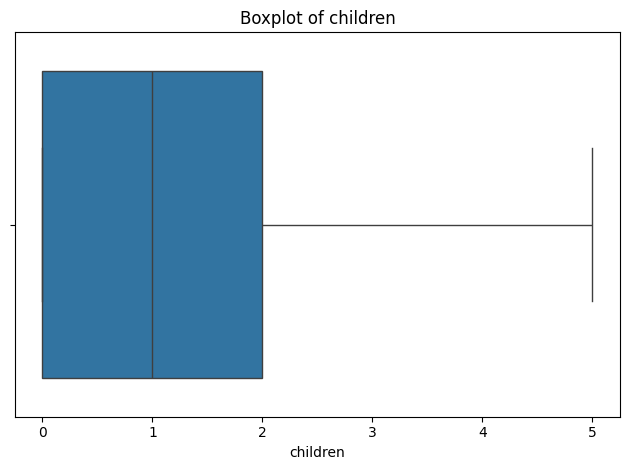

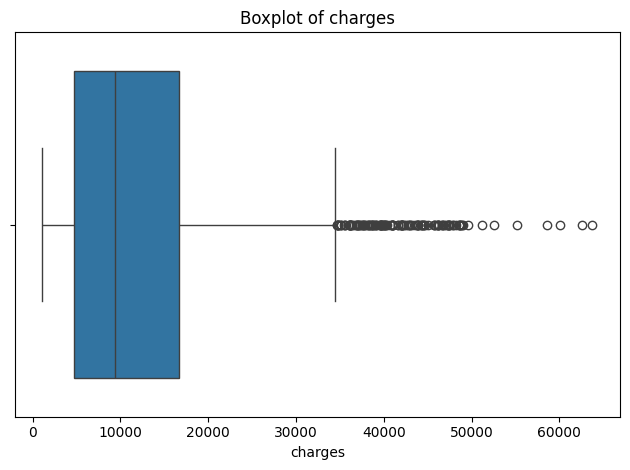

In [7]:
# 2.1.3 Boxplots for numeric features (to inspect outliers)

for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

<Figure size 1400x500 with 0 Axes>

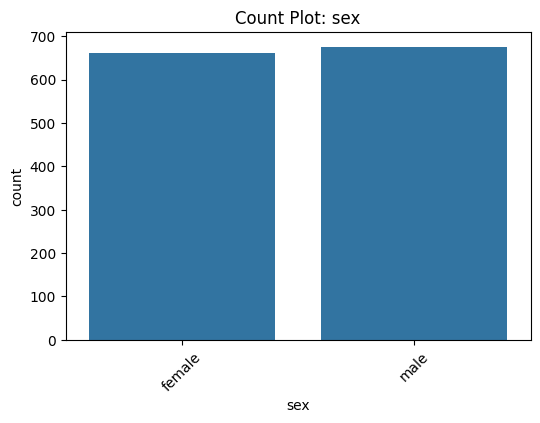

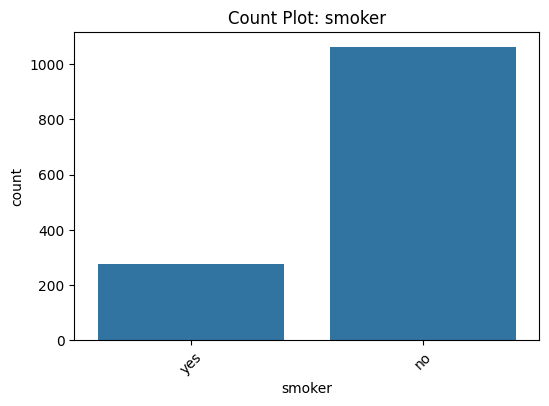

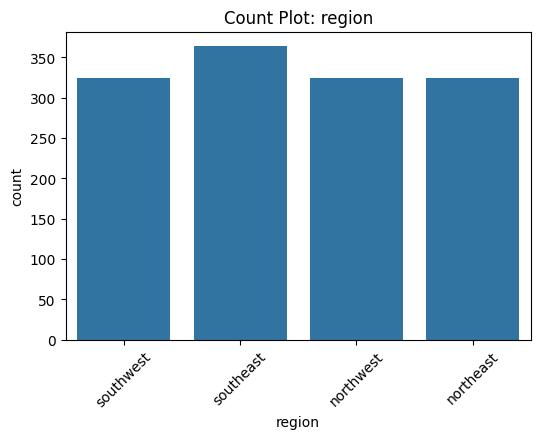

In [8]:
# Countplots for categorical columns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

if len(categorical_cols) > 0:
    plt.figure(figsize=(14, 5))
    for col in categorical_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col)
        plt.title(f"Count Plot: {col}")
        plt.xticks(rotation=45)
        plt.show()
else:
    print("No categorical columns to plot.")


### 2.2 Handle Missing Values and Clean Data


In [9]:


# Handle missing values and clean data

# Create a working copy
df_prepared = df.copy()

# Check missing values 
print("Missing values per column:")
print(df_prepared.isna().sum())

# Check duplicates 
print("\nDuplicate rows:", df_prepared.duplicated().sum())

# No cleaning or imputation needed for this dataset.
df_prepared.head()



Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Duplicate rows: 1


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
# Optional: Find possible outliers using Z-scores (exploration only)

from scipy.stats import zscore

z_scores = np.abs(zscore(df_prepared[numeric_cols]))
outlier_positions = np.where(z_scores > 3)

print("Number of potential outlier values:", len(outlier_positions[0]))


Number of potential outlier values: 29


### 2.3 Feature Selection and Engineering


In [11]:
# Review columns before feature engineering

df_prepared.columns.tolist()


['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [12]:
# Convert categorical variables to numeric using one-hot encoding

df_model = pd.get_dummies(df_prepared, drop_first=True)

# Convert boolean dummy columns to integers
bool_cols = df_model.select_dtypes(include='bool').columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

print("Shape of df_model:", df_model.shape)
df_model.head()



Shape of df_model: (1338, 9)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [13]:
# Transform or combine existing features to improve model performance
# BMI Over 30 (Obesity Flag)
df_model['bmi_over_30'] = (df_model['bmi'] > 30).astype(int)


In [14]:
# Age X BMI Interaction

df_model['age_bmi_interaction'] = df_model['age'] * df_model['bmi']


In [15]:
# Smoker and BMI Interaction
if 'smoker_yes' in df_model.columns:
    df_model['smoker_bmi_interaction'] = df_model['smoker_yes'] * df_model['bmi']


In [16]:
# Age Squared (non-linear age effects)
# Charges increase with age, but no linearly
df_model['age_squared'] = df_model['age'] ** 2



In [17]:
# Smoker X Age Interaction
df_model['smoker_age_interaction'] = df_model['smoker_yes'] * df_model['age']


In [18]:
# Has Children or Not
df_model['has_children'] = (df_model['children'] > 0).astype(int)


In [19]:
print("Added feature-engineered columns. Preview:")
df_model.head()

Added feature-engineered columns. Preview:


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_over_30,age_bmi_interaction,smoker_bmi_interaction,age_squared,smoker_age_interaction,has_children
0,19,27.900,0,16884.92400,0,1,0,0,1,0,530.100,27.9,361,19,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,607.860,0.0,324,0,1
2,28,33.000,3,4449.46200,1,0,0,1,0,1,924.000,0.0,784,0,1
3,33,22.705,0,21984.47061,1,0,1,0,0,0,749.265,0.0,1089,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,924.160,0.0,1024,0,0


### Reflection 2

- What patterns or anomalies do you see? 
  - Charges are very right skewed.
  - BMI is centered around 30.
  - Age seems to be evenly distributed.
 
- Do any features stand out?  
  - Even without modeling and just looking at the first couple of rows of data, smokers stand out as having very high charges.
  - BMI over 30 (obese) also seems like it will make an impact.

- What preprocessing steps were necessary to clean and improve the data?  
  - The only required step was to convert categorical variables to numeric.
  - There really were no other processing steps needed.  The dataset was very clean with no missing values and outliers seem to be realistic outliers.
  
- Did you create or modify any features to improve performance?  
  - Yes, I did.  
  - I created an obesity flag for the people over BMI of 30.
  - Age X BMI
  - Smoker X BMI
  - Smoker X Age
  - Age-squared
  - Has children 


## Section 3. Feature Selection and Justification

### 3.1 Choose features and target


In [20]:
# Choose features (X) and target (y)

# Target variable: insurance charges
target_col = "charges"

# Final selected feature set (balanced + effective)
feature_cols = [
    "age",
    "bmi",
    "children",
    "sex_male",
    "smoker_yes",
    "region_northwest",
    "region_southeast",
    "region_southwest",
    "bmi_over_30",
    "age_squared",
]

print("Target column:", target_col)
print("\nNumber of features selected:", len(feature_cols))
print("Feature columns:")
for col in feature_cols:
    print(" -", col)


Target column: charges

Number of features selected: 10
Feature columns:
 - age
 - bmi
 - children
 - sex_male
 - smoker_yes
 - region_northwest
 - region_southeast
 - region_southwest
 - bmi_over_30
 - age_squared


### 3.2 Define X and y from df_model

In [21]:
# Define X and y

X = df_model[feature_cols].copy()
y = df_model[target_col].copy()

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

X.head()


Shape of X (features): (1338, 10)
Shape of y (target): (1338,)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_over_30,age_squared
0,19,27.900,0,0,1,0,0,1,0,361
1,18,33.770,1,1,0,0,1,0,1,324
2,28,33.000,3,1,0,0,1,0,1,784
3,33,22.705,0,1,0,1,0,0,0,1089
4,32,28.880,0,1,0,1,0,0,0,1024


#### Reflection 3.  

- Why did you choose these features?
  - I selected charges as my y variable because it is a continuous measure which makes it good for regression project.  It also seems to be the most logical thing to pick here because we want to use the other features to determine charges.
  - I included age and BMI  and "smoking status" because they are very good predictors of medical charges.  Obese people, smokers and the elderly have more comorbidities than the rest of the public.  I also included regions and sex to see if different areas of the country spend more on medical expenses and whether men or women tend to have higher medical charges.
  - I also included BMI_over_30 because age and BMI combined make a better predictor than either one alone.

- How might they impact predictions or accuracy?
  - Overall, the features I chose seem to be the most relevant for prediction for medical charges.  BMI, Age, Smoking Status, and Age are all very good predictors.   I am not sure if the regions or sex will impact predictions much, but I would like to find out.

## Section 4. Train a Model (Linear Regression)


### 4.1 Split the data into training and test sets


In [22]:
# Split data into training and test sets



X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (1070, 10)
Test set shape: (268, 10)


### 4.2 Train the Linear Regression model


In [23]:
# Train the Linear Regression model

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Model training complete.")


Model training complete.


### 4.3 Evaluate performance (R², MAE, RMSE)


In [24]:
# Evaluate model performance

# Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=== Linear Regression Performance ===")
print(f"Train R²:  {train_r2:.4f}")
print(f"Test R²:   {test_r2:.4f}")

print(f"\nTrain MAE: {train_mae:,.2f}")
print(f"Test MAE:  {test_mae:,.2f}")

print(f"\nTrain RMSE: {train_rmse:,.2f}")
print(f"Test RMSE:  {test_rmse:,.2f}")


=== Linear Regression Performance ===
Train R²:  0.7503
Test R²:   0.7874

Train MAE: 4,231.43
Test MAE:  4,203.89

Train RMSE: 6,003.55
Test RMSE:  5,745.29


### Section 4.4  Optional:  Feature Influence (Coefficient Analysis)


To better understand which factors contribute most to predicted medical insurance charges, I examined the coefficients of the baseline Linear Regression model. Positive coefficients indicate features that increase predicted charges, while negative coefficients indicate features that decrease them.

The analysis includes both original features and engineered features such as `bmi_over_30` and `age_squared`.



In [25]:
# Optional: Examine feature coefficients for baseline Linear Regression

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lin_reg.coef_
}).sort_values("Coefficient", ascending=False)

coef_df


,Feature,Coefficient
4,smoker_yes,23621.419621
8,bmi_over_30,3081.305129
2,children,552.205424
1,bmi,122.512657
9,age_squared,3.385982
0,age,-10.951681
3,sex_male,-26.876388
5,region_northwest,-404.640026
6,region_southeast,-507.519595
7,region_southwest,-767.808181


Coefficient Bar Plot

C:\Users\beths\AppData\Local\Temp\ipykernel_1280\2033046669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")


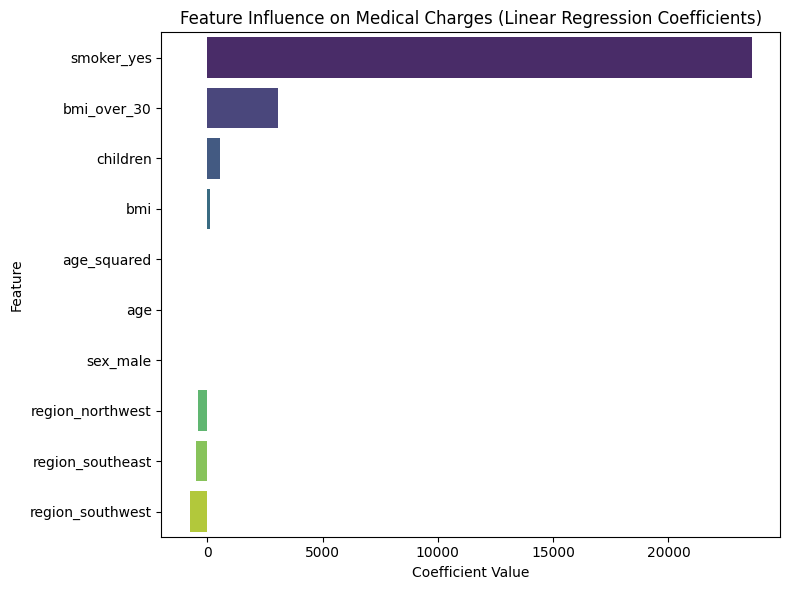

In [26]:
plt.figure(figsize=(8,6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")
plt.title("Feature Influence on Medical Charges (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


C:\Users\beths\AppData\Local\Temp\ipykernel_1280\3192776017.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=small_features, x="Coefficient", y="Feature", palette="mako")


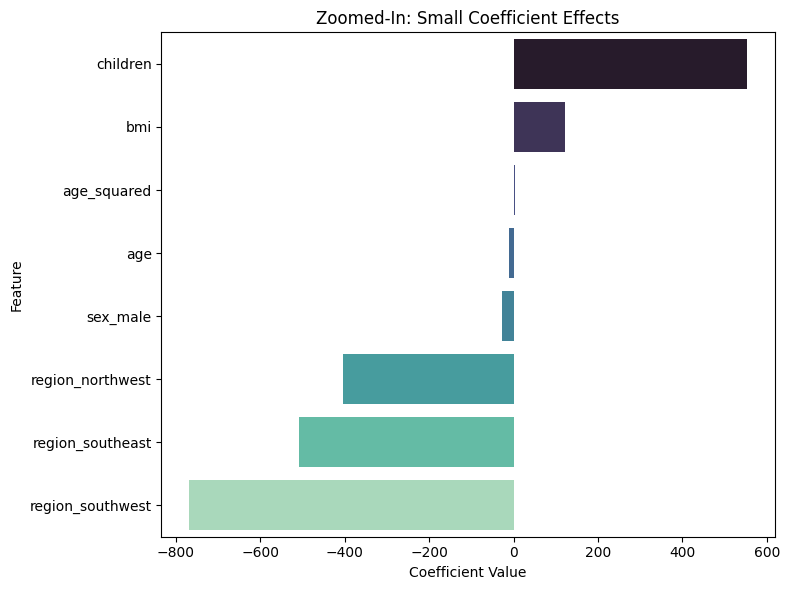

In [27]:
# Filter out 'smoker_yes' and 'bmi_over_30' so small features are visible
small_features = coef_df[coef_df["Feature"].isin([
    "age",
    "age_squared",
    "bmi",
    "children",
    "sex_male",
    "region_northwest",
    "region_southeast",
    "region_southwest"
])]

plt.figure(figsize=(8,6))
sns.barplot(data=small_features, x="Coefficient", y="Feature", palette="mako")
plt.title("Zoomed-In: Small Coefficient Effects")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Interpretation of Feature Influence

Overall, the analysis shows that lifestyle factors like smoking and obesity have the strongest influence on insurance charges, while age contributes in a nonlinear way.


### Reflection 4

- How well did the model perform?
  - The model did decently well in predicting insurance charges knowing how unpredictable and skewed costs can be.  
  - The R² shows how much variation in charges the model could explain.  
  - The MAE and RMSE tell us how far off our predictions were. The RMSE is higher than the MAE because the claims are so large that they create large squared error.
  - The test performance ws lower than the training performance which indicates overfitting.  This is most likely because the insurance charges are very skewed due to features like smokers and higher BMI patients.

- Any surprises in the results?
  - Overall, there is nothing surprising in the results.


## Section 5. Improve the Model or Try Alternates (Implement Pipelines)

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [28]:
# Pipeline 1: Imputer → StandardScaler → Linear Regression

pipeline_1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_1.fit(X_train, y_train)

print("Pipeline 1 training complete.")


Pipeline 1 training complete.


### 5.2 Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression


In [29]:
# Pipeline 2: Polynomial Features → Scaler → Linear Regression

pipeline_2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_2.fit(X_train, y_train)

print("Pipeline 2 (Polynomial Regression) training complete.")


Pipeline 2 (Polynomial Regression) training complete.


In [30]:
# Function to evaluate any model

def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    return {
        "Train R²": r2_score(y_train, train_pred),
        "Test R²": r2_score(y_test, test_pred),
        "Train MAE": mean_absolute_error(y_train, train_pred),
        "Test MAE": mean_absolute_error(y_test, test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, train_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, test_pred)),
    }


In [31]:
results_pipeline_1 = evaluate_model(pipeline_1, X_train, X_test, y_train, y_test)
results_pipeline_2 = evaluate_model(pipeline_2, X_train, X_test, y_train, y_test)

results_pipeline_1, results_pipeline_2


({'Train R²': 0.7502825700060458,
  'Test R²': 0.7873839135754972,
  'Train MAE': 4231.429718370559,
  'Test MAE': 4203.894636028393,
  'Train RMSE': np.float64(6003.550710276769),
  'Test RMSE': np.float64(5745.2917865108775)},
 {'Train R²': 0.8827332213286971,
  'Test R²': 0.8599821176702955,
  'Train MAE': 2379.920422727272,
  'Test MAE': 2757.797664529478,
  'Train RMSE': np.float64(4114.065981247985),
  'Test RMSE': np.float64(4662.3597692425055)})

In [32]:


comparison_df = pd.DataFrame([
    {
        "Model": "Baseline Linear Regression",
        **{
            "Train R²": train_r2,
            "Test R²": test_r2,
            "Train MAE": train_mae,
            "Test MAE": test_mae,
            "Train RMSE": train_rmse,
            "Test RMSE": test_rmse,
        }
    },
    {"Model": "Pipeline 1 (Scaled Linear Regression)", **results_pipeline_1},
    {"Model": "Pipeline 2 (Polynomial Degree 3)", **results_pipeline_2},
])

comparison_df.set_index("Model")


,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
Model,,,,,,
Baseline Linear Regression,0.750283,0.787384,4231.429718,4203.894636,6003.550710,5745.291787
Pipeline 1 (Scaled Linear Regression),0.750283,0.787384,4231.429718,4203.894636,6003.550710,5745.291787
Pipeline 2 (Polynomial Degree 3),0.882733,0.859982,2379.920423,2757.797665,4114.065981,4662.359769


### Reflection 5

Pipeline 1, which added scaling, produced the same results as the baseline model. This is expected because simple linear regression doesn’t need feature scaling, and the relationships between the variables stay the same even after scaling, so it was no surprise that the two models performed identically.

Pipeline 2, polynomial features of degree 3, performed much better. The polynomial model had a higher R² score, and reduced the MAE and RMSE on both the training and test sets. This shows that the polynomial features allowed the model to more accurately capture nonlinear relationships in the insurance data, something that the basic linear model did not do as well with.  Although the polynomial model did have a slight problem with overfitting, where its training score was higher than its test score, the test score was still noticeably better compared to the baseline.

Overall, the Polynomial Regression model performed the best among the three. Scaling alone did not improve accuracy, but adding polynomial terms allowed the model to fit the underlying patterns in the data better.




## Section 6. Final Thoughts and Insights


### 6.1 Summarize Findings

This project explored how different features influenced medical insurance charges. I trained multiple versions of Linear Regression models. The baseline linear model performed reasonably well, explaining around 78% of the variation in insurance charges. 

Adding standard scaling through Pipeline 1 did not change performance, which is expected for ordinary Linear Regression. Pipeline 2, which included polynomial features of degree 3, produced the best overall results with higher R² scores and lower MAE and RMSE. 


### 6.2 Discuss Challenges Faced

I did not face very challenges in this project.  One challenge was interpreting which models were most appropriate and making sure to use the right evaluation metrics for regression rather than classification. 


### 6.3 If You Had More Time, What Would You Try Next?

With more time, I would explore additional modeling approaches beyond Linear Regression. Models like Ridge Regression, Lasso, Random Forests, or Gradient Boosting could potentially handle nonlinear relationships and interactions even more effectively. 


### Reflection 6

Through this project, I learned how the full workflow of a regression analysis comes together.  I have a better understanding of how different preprocessing steps, such as encoding and scaling, impact model results. It was also helpful to see why more complex models may perform better on real data.

Overall, I enjoyed working with this project from start to finish.  I do feel like I may have randomly picked a very easy dataset, though, since this dataset had no major outliers or missing data.


### Bonus: SHAP-Based Model Interpretation (Advanced)

To better understand how the model is using each feature for individual predictions, we can use SHAP values.

SHAP is a modern interpretability technique that:

- Assigns each feature a contribution (positive or negative) to the prediction for each person.
- Helps us see which features consistently increase or decrease predicted charges.
- Is widely used in real world machine learning systems to explain model behavior.

Here, we apply SHAP to the baseline Linear Regression model trained on the original feature set. This makes the explanations easier to interpret (one value per feature, without all the polynomial terms).


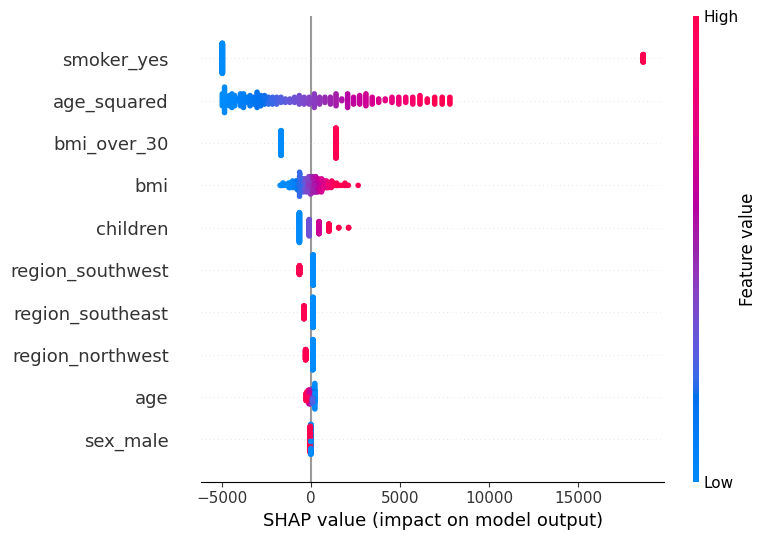

In [33]:
# SHAP interpretation for the baseline Linear Regression model

# Initialize JS visualization (works nicely in Jupyter environments)
shap.initjs()

# For SHAP, we pick a smaller "background" sample to speed things up
background = X_train.sample(min(200, len(X_train)), random_state=42)

# Create an explainer for the baseline linear regression model
# If your baseline model has a different name than lin_reg, replace it here.
explainer = shap.Explainer(lin_reg, background)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot: shows overall importance and direction of effect
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_cols,
    show=True
)


### Bonus: Interactive What-If Cost Predictor

As a bonus, I created a simple interactive tool that uses the trained polynomial regression model (Pipeline 2) to estimate medical insurance charges based on inputs chosen by the user. By adjusting sliders and dropdowns for age, BMI, number of children, sex, smoker status, and region, we can see how the predicted cost changes. This provides an intuitive "what-if" view of the model and helps connect the numeric results to real-world scenarios.


In [34]:
# Bonus: Interactive What-If Cost Predictor

# Use the same feature list that we used for model training
final_features = feature_cols.copy()

def predict_insurance_cost(age, bmi, children, sex, smoker, region):
    """Build a single-row DataFrame and use pipeline_2 to predict charges."""
    # Start with all features set to 0
    row = {col: 0 for col in final_features}

    # Core numeric features
    row["age"] = age
    row["bmi"] = bmi
    row["children"] = children

    # Categorical: sex (only sex_male is in our features; Female is the baseline)
    row["sex_male"] = 1 if sex == "Male" else 0

    # Categorical: smoker (only smoker_yes; non-smoker is baseline)
    row["smoker_yes"] = 1 if smoker == "Smoker" else 0

    # Categorical: region (northeast is the baseline when all are 0)
    row["region_northwest"] = 1 if region == "northwest" else 0
    row["region_southeast"] = 1 if region == "southeast" else 0
    row["region_southwest"] = 1 if region == "southwest" else 0

    # Engineered features (must match how df_model was created)
    row["bmi_over_30"] = 1 if bmi > 30 else 0
    row["age_squared"] = age ** 2

    # Turn into a DataFrame with the exact same columns as X
    X_new = pd.DataFrame([row], columns=final_features)

    # Use the polynomial pipeline (Pipeline 2) for prediction
    predicted_charge = pipeline_2.predict(X_new)[0]

    # Nicely formatted output
    print(f"Estimated yearly insurance cost: ${predicted_charge:,.0f}")
    print("\nInputs used:")
    print(f" - Age: {age}")
    print(f" - BMI: {bmi:.1f}")
    print(f" - Children: {children}")
    print(f" - Sex: {sex}")
    print(f" - Smoker: {smoker}")
    print(f" - Region: {region.title()}")    

# Define sliders and dropdowns
age_slider = widgets.IntSlider(
    value=40, min=18, max=64, step=1, description="Age", continuous_update=False
)

bmi_slider = widgets.FloatSlider(
    value=30.0, min=15.0, max=45.0, step=0.1, description="BMI", continuous_update=False
)

children_slider = widgets.IntSlider(
    value=0, min=0, max=5, step=1, description="Children", continuous_update=False
)

sex_dropdown = widgets.Dropdown(
    options=["Female", "Male"], value="Female", description="Sex"
)

smoker_dropdown = widgets.Dropdown(
    options=["Non-smoker", "Smoker"], value="Non-smoker", description="Smoker"
)

region_dropdown = widgets.Dropdown(
    options=["northeast", "northwest", "southeast", "southwest"],
    value="northeast",
    description="Region"
)

# Lay out the controls
ui = widgets.VBox([
    widgets.HTML("<b>Adjust the sliders and dropdowns to see how the predicted cost changes.</b>"),
    widgets.HBox([age_slider, bmi_slider]),
    widgets.HBox([children_slider, sex_dropdown]),
    widgets.HBox([smoker_dropdown, region_dropdown]),
])

# Connect widgets to the prediction function
out = widgets.interactive_output(
    predict_insurance_cost,
    {
        "age": age_slider,
        "bmi": bmi_slider,
        "children": children_slider,
        "sex": sex_dropdown,
        "smoker": smoker_dropdown,
        "region": region_dropdown,
    }
)

display(ui, out)


Output()